# Metal Coordinating Network Oscillation

Fit oscillatory sweep of metal-coordinating polymer network.

**Data:** examples/data/pyRheo/metal_coordinating_polymer_network/epstein.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.models.herschel_bulkley import HerschelBulkley
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)
import arviz as az


INFO:2025-12-07 17:21:48,767:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load frequency sweep

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyRheo' / 'metal_coordinating_polymer_network'
df = pd.read_csv(DATA_DIR / 'epstein.csv', sep='	')
df.columns = df.columns.str.strip()
omega = df.iloc[:,0].to_numpy()
Gp = df.iloc[:,1].to_numpy()
Gpp = df.iloc[:,2].to_numpy()
G_star = Gp + 1j*Gpp


## Fit models

In [4]:
gm = GeneralizedMaxwell(n_modes=4, modulus_type='tensile')
gm.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
gm_pred_components = gm.predict(omega)
gm_pred = gm_pred_components[:,0] + 1j*gm_pred_components[:,1]
gm_r2 = r2_complex(G_star, gm_pred)

fm_pred = np.full_like(G_star, np.nan)
fm_r2 = np.nan
try:
    fm = FractionalMaxwellModel()
    fm.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
    fm_pred = fm.predict(omega, test_mode='oscillation')
    fm_r2 = r2_complex(G_star, fm_pred)
except Exception as exc:
    print(f"Fractional Maxwell fit failed: {exc}")

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.334735s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=3.698311e+03 | time=1.335s | final_gradient_norm=638450475.4277151


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.316268s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=3.698311e+03 | time=0.316s | final_gradient_norm=638450475.4277151


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.602432s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=1.151489e+04 | time=0.602s | final_gradient_norm=491880798.92526704


Element minimization: early termination at n_modes=3 (R²=0.999030 < threshold=0.999532)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.277149s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=41 | final_cost=2.416133e-01 | time=1.277s | final_gradient_norm=0.000871384844828038


{'gm_r2': 0.9996876727417076, 'fm_r2': -1.5293247656507165}


## Plot fits

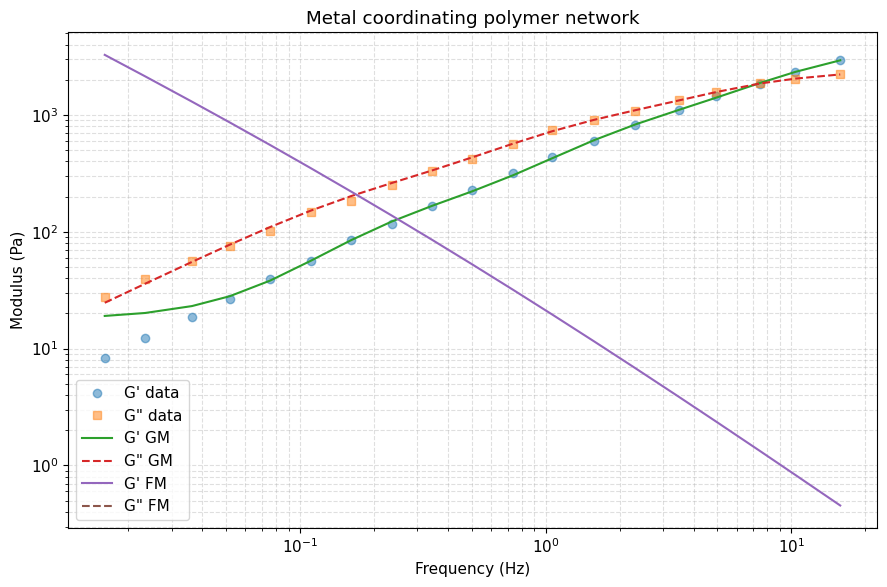

In [5]:
freq_hz = omega/(2*np.pi)
fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(freq_hz, np.real(G_star), 'o', label="G' data", alpha=0.5)
ax.loglog(freq_hz, np.imag(G_star), 's', label='G" data', alpha=0.5)
ax.loglog(freq_hz, np.real(gm_pred), '-', label="G' GM")
ax.loglog(freq_hz, np.imag(gm_pred), '--', label='G" GM')
if np.isfinite(fm_r2):
    ax.loglog(freq_hz, np.real(fm_pred), '-', label="G' FM")
    ax.loglog(freq_hz, np.imag(fm_pred), '--', label='G" FM')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Modulus (Pa)')
ax.set_title('Metal coordinating polymer network')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.314030s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=3.698311e+03 | time=0.314s | final_gradient_norm=638450475.4277151


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.325789s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=3.698311e+03 | time=0.326s | final_gradient_norm=638450475.4277151


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.205454s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=16 | final_cost=1.151489e+04 | time=0.205s | final_gradient_norm=491880798.92526704


Element minimization: early termination at n_modes=3 (R²=0.999030 < threshold=0.999532)


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.446047s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=41 | final_cost=2.416133e-01 | time=0.446s | final_gradient_norm=0.000871384844828038


Model ranking (R²): [('gm', 1.0), ('fm', -1.529)]


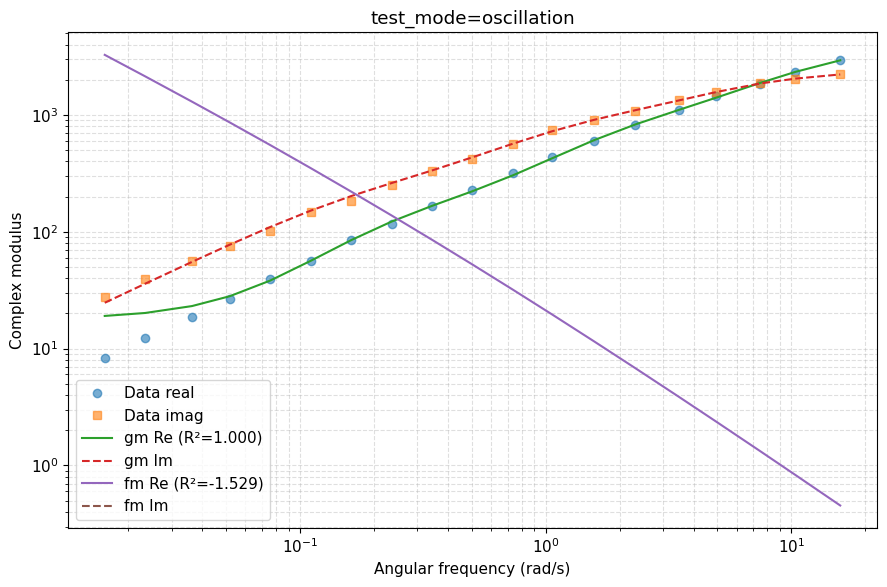

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<58:31,  1.14it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 42/4000 [00:00<01:08, 57.43it/s, 1023 steps of size 1.04e-02. acc. prob=0.73]

warmup:   2%|▏         | 84/4000 [00:01<00:33, 116.02it/s, 511 steps of size 2.02e-02. acc. prob=0.76]

warmup:   4%|▍         | 164/4000 [00:01<00:15, 245.10it/s, 127 steps of size 4.93e-02. acc. prob=0.77]

warmup:   7%|▋         | 298/4000 [00:01<00:07, 476.72it/s, 63 steps of size 8.90e-02. acc. prob=0.78] 

warmup:  11%|█▏        | 458/4000 [00:01<00:04, 733.16it/s, 255 steps of size 4.38e-02. acc. prob=0.78]

warmup:  15%|█▌        | 608/4000 [00:01<00:03, 922.45it/s, 15 steps of size 2.49e-01. acc. prob=0.79] 

warmup:  20%|█▉        | 788/4000 [00:01<00:02, 1150.63it/s, 31 steps of size 1.80e-01. acc. prob=0.79]

warmup:  24%|██▍       | 962/4000 [00:01<00:02, 1306.01it/s, 127 steps of size 4.68e-02. acc. prob=0.79]

sample:  28%|██▊       | 1114/4000 [00:01<00:02, 1365.02it/s, 31 steps of size 1.61e-01. acc. prob=0.93]

sample:  32%|███▏      | 1268/4000 [00:01<00:01, 1412.62it/s, 31 steps of size 1.61e-01. acc. prob=0.93]

sample:  36%|███▌      | 1424/4000 [00:02<00:01, 1453.71it/s, 31 steps of size 1.61e-01. acc. prob=0.93]

sample:  40%|███▉      | 1586/4000 [00:02<00:01, 1500.37it/s, 31 steps of size 1.61e-01. acc. prob=0.93]

sample:  44%|████▎     | 1744/4000 [00:02<00:01, 1521.79it/s, 31 steps of size 1.61e-01. acc. prob=0.93]

sample:  48%|████▊     | 1900/4000 [00:02<00:01, 1530.28it/s, 31 steps of size 1.61e-01. acc. prob=0.93]

sample:  51%|█████▏    | 2056/4000 [00:02<00:01, 1525.62it/s, 31 steps of size 1.61e-01. acc. prob=0.93]

sample:  55%|█████▌    | 2211/4000 [00:02<00:01, 1529.72it/s, 15 steps of size 1.61e-01. acc. prob=0.93]

sample:  59%|█████▉    | 2369/4000 [00:02<00:01, 1543.40it/s, 31 steps of size 1.61e-01. acc. prob=0.93]

sample:  63%|██████▎   | 2528/4000 [00:02<00:00, 1554.55it/s, 31 steps of size 1.61e-01. acc. prob=0.92]

sample:  67%|██████▋   | 2685/4000 [00:02<00:00, 1550.68it/s, 31 steps of size 1.61e-01. acc. prob=0.92]

sample:  71%|███████   | 2841/4000 [00:02<00:00, 1538.07it/s, 31 steps of size 1.61e-01. acc. prob=0.92]

sample:  75%|███████▌  | 3003/4000 [00:03<00:00, 1559.96it/s, 31 steps of size 1.61e-01. acc. prob=0.92]

sample:  79%|███████▉  | 3160/4000 [00:03<00:00, 1558.99it/s, 31 steps of size 1.61e-01. acc. prob=0.92]

sample:  83%|████████▎ | 3317/4000 [00:03<00:00, 1553.74it/s, 31 steps of size 1.61e-01. acc. prob=0.92]

sample:  87%|████████▋ | 3476/4000 [00:03<00:00, 1562.65it/s, 31 steps of size 1.61e-01. acc. prob=0.92]

sample:  91%|█████████ | 3633/4000 [00:03<00:00, 1555.31it/s, 31 steps of size 1.61e-01. acc. prob=0.92]

sample:  95%|█████████▍| 3792/4000 [00:03<00:00, 1563.01it/s, 31 steps of size 1.61e-01. acc. prob=0.92]

sample:  99%|█████████▊| 3949/4000 [00:03<00:00, 1538.02it/s, 31 steps of size 1.61e-01. acc. prob=0.92]

sample: 100%|██████████| 4000/4000 [00:03<00:00, 1093.57it/s, 15 steps of size 1.61e-01. acc. prob=0.92]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 28/4000 [00:00<00:14, 277.95it/s, 63 steps of size 3.01e-02. acc. prob=0.73]

warmup:   2%|▏         | 67/4000 [00:00<00:11, 343.01it/s, 255 steps of size 1.99e-02. acc. prob=0.76]

warmup:   3%|▎         | 102/4000 [00:00<00:12, 320.49it/s, 15 steps of size 6.78e-02. acc. prob=0.76]

warmup:   6%|▌         | 236/4000 [00:00<00:05, 703.07it/s, 15 steps of size 3.06e-01. acc. prob=0.78]

warmup:   9%|▉         | 376/4000 [00:00<00:03, 944.32it/s, 63 steps of size 1.13e-01. acc. prob=0.78]

warmup:  13%|█▎        | 526/4000 [00:00<00:03, 1126.90it/s, 31 steps of size 2.37e-01. acc. prob=0.79]

warmup:  17%|█▋        | 689/4000 [00:00<00:02, 1287.16it/s, 31 steps of size 1.25e-01. acc. prob=0.79]

warmup:  22%|██▏       | 861/4000 [00:00<00:02, 1422.58it/s, 15 steps of size 2.51e-01. acc. prob=0.79]

sample:  25%|██▌       | 1013/4000 [00:00<00:02, 1449.80it/s, 63 steps of size 1.25e-01. acc. prob=0.96]

sample:  29%|██▉       | 1159/4000 [00:01<00:01, 1428.03it/s, 31 steps of size 1.25e-01. acc. prob=0.95]

sample:  33%|███▎      | 1303/4000 [00:01<00:01, 1414.71it/s, 31 steps of size 1.25e-01. acc. prob=0.95]

sample:  36%|███▌      | 1446/4000 [00:01<00:01, 1417.26it/s, 31 steps of size 1.25e-01. acc. prob=0.95]

sample:  40%|███▉      | 1590/4000 [00:01<00:01, 1422.27it/s, 31 steps of size 1.25e-01. acc. prob=0.96]

sample:  43%|████▎     | 1733/4000 [00:01<00:01, 1335.42it/s, 23 steps of size 1.25e-01. acc. prob=0.96]

sample:  47%|████▋     | 1872/4000 [00:01<00:01, 1349.07it/s, 31 steps of size 1.25e-01. acc. prob=0.96]

sample:  50%|█████     | 2014/4000 [00:01<00:01, 1368.67it/s, 31 steps of size 1.25e-01. acc. prob=0.96]

sample:  54%|█████▍    | 2156/4000 [00:01<00:01, 1382.92it/s, 31 steps of size 1.25e-01. acc. prob=0.96]

sample:  57%|█████▋    | 2299/4000 [00:01<00:01, 1395.53it/s, 31 steps of size 1.25e-01. acc. prob=0.96]

sample:  61%|██████    | 2444/4000 [00:01<00:01, 1411.15it/s, 31 steps of size 1.25e-01. acc. prob=0.96]

sample:  65%|██████▍   | 2588/4000 [00:02<00:00, 1418.51it/s, 31 steps of size 1.25e-01. acc. prob=0.96]

sample:  68%|██████▊   | 2733/4000 [00:02<00:00, 1427.29it/s, 31 steps of size 1.25e-01. acc. prob=0.96]

sample:  72%|███████▏  | 2876/4000 [00:02<00:00, 1425.60it/s, 31 steps of size 1.25e-01. acc. prob=0.96]

sample:  75%|███████▌  | 3019/4000 [00:02<00:00, 1424.68it/s, 31 steps of size 1.25e-01. acc. prob=0.96]

sample:  79%|███████▉  | 3162/4000 [00:02<00:00, 1425.95it/s, 31 steps of size 1.25e-01. acc. prob=0.96]

sample:  83%|████████▎ | 3305/4000 [00:02<00:00, 1415.81it/s, 31 steps of size 1.25e-01. acc. prob=0.96]

sample:  86%|████████▌ | 3447/4000 [00:02<00:00, 1409.97it/s, 31 steps of size 1.25e-01. acc. prob=0.96]

sample:  90%|████████▉ | 3590/4000 [00:02<00:00, 1413.94it/s, 63 steps of size 1.25e-01. acc. prob=0.96]

sample:  93%|█████████▎| 3737/4000 [00:02<00:00, 1430.41it/s, 31 steps of size 1.25e-01. acc. prob=0.96]

sample:  97%|█████████▋| 3881/4000 [00:02<00:00, 1420.84it/s, 31 steps of size 1.25e-01. acc. prob=0.96]

sample: 100%|██████████| 4000/4000 [00:03<00:00, 1312.03it/s, 31 steps of size 1.25e-01. acc. prob=0.96]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 24/4000 [00:00<00:16, 238.46it/s, 127 steps of size 5.03e-03. acc. prob=0.69]

warmup:   1%|          | 48/4000 [00:00<00:18, 213.80it/s, 255 steps of size 4.05e-02. acc. prob=0.75]

warmup:   2%|▏         | 79/4000 [00:00<00:15, 251.69it/s, 1023 steps of size 1.32e-02. acc. prob=0.76]

warmup:   4%|▍         | 160/4000 [00:00<00:08, 461.69it/s, 127 steps of size 5.36e-02. acc. prob=0.77]

warmup:   7%|▋         | 287/4000 [00:00<00:04, 744.05it/s, 127 steps of size 7.37e-02. acc. prob=0.78]

warmup:  11%|█         | 439/4000 [00:00<00:03, 1002.34it/s, 31 steps of size 1.92e-01. acc. prob=0.79]

warmup:  15%|█▍        | 597/4000 [00:00<00:02, 1186.21it/s, 31 steps of size 2.34e-01. acc. prob=0.79]

warmup:  19%|█▉        | 774/4000 [00:00<00:02, 1367.82it/s, 31 steps of size 2.39e-01. acc. prob=0.79]

warmup:  24%|██▍       | 959/4000 [00:00<00:02, 1515.42it/s, 63 steps of size 1.67e-01. acc. prob=0.79]

sample:  28%|██▊       | 1112/4000 [00:01<00:01, 1465.01it/s, 31 steps of size 1.30e-01. acc. prob=0.96]

sample:  32%|███▏      | 1260/4000 [00:01<00:01, 1452.76it/s, 15 steps of size 1.30e-01. acc. prob=0.93]

sample:  35%|███▌      | 1406/4000 [00:01<00:01, 1438.92it/s, 31 steps of size 1.30e-01. acc. prob=0.94]

sample:  39%|███▉      | 1551/4000 [00:01<00:01, 1437.15it/s, 15 steps of size 1.30e-01. acc. prob=0.94]

sample:  42%|████▏     | 1696/4000 [00:01<00:01, 1435.41it/s, 31 steps of size 1.30e-01. acc. prob=0.94]

sample:  46%|████▌     | 1840/4000 [00:01<00:01, 1425.05it/s, 31 steps of size 1.30e-01. acc. prob=0.94]

sample:  50%|████▉     | 1988/4000 [00:01<00:01, 1438.94it/s, 31 steps of size 1.30e-01. acc. prob=0.95]

sample:  53%|█████▎    | 2133/4000 [00:01<00:01, 1437.77it/s, 31 steps of size 1.30e-01. acc. prob=0.95]

sample:  57%|█████▋    | 2277/4000 [00:01<00:01, 1431.59it/s, 31 steps of size 1.30e-01. acc. prob=0.95]

sample:  61%|██████    | 2422/4000 [00:01<00:01, 1436.17it/s, 15 steps of size 1.30e-01. acc. prob=0.95]

sample:  64%|██████▍   | 2566/4000 [00:02<00:01, 1433.57it/s, 15 steps of size 1.30e-01. acc. prob=0.95]

sample:  68%|██████▊   | 2710/4000 [00:02<00:00, 1417.95it/s, 15 steps of size 1.30e-01. acc. prob=0.95]

sample:  71%|███████▏  | 2853/4000 [00:02<00:00, 1420.89it/s, 31 steps of size 1.30e-01. acc. prob=0.95]

sample:  75%|███████▍  | 2996/4000 [00:02<00:00, 1417.31it/s, 31 steps of size 1.30e-01. acc. prob=0.95]

sample:  78%|███████▊  | 3139/4000 [00:02<00:00, 1420.65it/s, 31 steps of size 1.30e-01. acc. prob=0.95]

sample:  82%|████████▏ | 3282/4000 [00:02<00:00, 1416.47it/s, 31 steps of size 1.30e-01. acc. prob=0.95]

sample:  86%|████████▌ | 3424/4000 [00:02<00:00, 1405.66it/s, 31 steps of size 1.30e-01. acc. prob=0.95]

sample:  89%|████████▉ | 3567/4000 [00:02<00:00, 1409.73it/s, 31 steps of size 1.30e-01. acc. prob=0.95]

sample:  93%|█████████▎| 3712/4000 [00:02<00:00, 1420.15it/s, 31 steps of size 1.30e-01. acc. prob=0.95]

sample:  96%|█████████▋| 3856/4000 [00:02<00:00, 1425.20it/s, 15 steps of size 1.30e-01. acc. prob=0.95]

sample: 100%|█████████▉| 3999/4000 [00:03<00:00, 1419.29it/s, 63 steps of size 1.30e-01. acc. prob=0.95]

sample: 100%|██████████| 4000/4000 [00:03<00:00, 1302.98it/s, 31 steps of size 1.30e-01. acc. prob=0.95]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   1%|          | 37/4000 [00:00<00:10, 363.05it/s, 127 steps of size 2.66e-02. acc. prob=0.74]

warmup:   2%|▏         | 74/4000 [00:00<00:10, 364.78it/s, 255 steps of size 2.05e-02. acc. prob=0.76]

warmup:   3%|▎         | 117/4000 [00:00<00:09, 393.33it/s, 127 steps of size 7.04e-02. acc. prob=0.77]

warmup:   6%|▌         | 241/4000 [00:00<00:05, 724.46it/s, 15 steps of size 2.43e-01. acc. prob=0.78] 

warmup:  10%|▉         | 399/4000 [00:00<00:03, 1029.40it/s, 63 steps of size 8.46e-02. acc. prob=0.78]

warmup:  14%|█▍        | 551/4000 [00:00<00:02, 1194.33it/s, 15 steps of size 2.74e-01. acc. prob=0.79]

warmup:  18%|█▊        | 725/4000 [00:00<00:02, 1370.73it/s, 15 steps of size 1.20e-01. acc. prob=0.79]

warmup:  23%|██▎       | 904/4000 [00:00<00:02, 1503.33it/s, 15 steps of size 2.63e-01. acc. prob=0.79]

sample:  26%|██▋       | 1057/4000 [00:00<00:01, 1508.72it/s, 31 steps of size 1.49e-01. acc. prob=0.92]

sample:  30%|███       | 1208/4000 [00:01<00:01, 1499.81it/s, 31 steps of size 1.49e-01. acc. prob=0.93]

sample:  34%|███▍      | 1359/4000 [00:01<00:01, 1483.53it/s, 15 steps of size 1.49e-01. acc. prob=0.93]

sample:  38%|███▊      | 1508/4000 [00:01<00:01, 1466.56it/s, 31 steps of size 1.49e-01. acc. prob=0.94]

sample:  41%|████▏     | 1657/4000 [00:01<00:01, 1470.41it/s, 31 steps of size 1.49e-01. acc. prob=0.94]

sample:  45%|████▌     | 1805/4000 [00:01<00:01, 1464.00it/s, 31 steps of size 1.49e-01. acc. prob=0.94]

sample:  49%|████▉     | 1952/4000 [00:01<00:01, 1463.05it/s, 31 steps of size 1.49e-01. acc. prob=0.94]

sample:  53%|█████▎    | 2102/4000 [00:01<00:01, 1473.68it/s, 31 steps of size 1.49e-01. acc. prob=0.94]

sample:  56%|█████▋    | 2257/4000 [00:01<00:01, 1494.67it/s, 31 steps of size 1.49e-01. acc. prob=0.94]

sample:  60%|██████    | 2412/4000 [00:01<00:01, 1508.07it/s, 31 steps of size 1.49e-01. acc. prob=0.94]

sample:  64%|██████▍   | 2563/4000 [00:01<00:01, 1427.33it/s, 31 steps of size 1.49e-01. acc. prob=0.94]

sample:  68%|██████▊   | 2710/4000 [00:02<00:00, 1438.72it/s, 31 steps of size 1.49e-01. acc. prob=0.94]

sample:  71%|███████▏  | 2855/4000 [00:02<00:00, 1440.90it/s, 31 steps of size 1.49e-01. acc. prob=0.94]

sample:  75%|███████▌  | 3006/4000 [00:02<00:00, 1459.70it/s, 31 steps of size 1.49e-01. acc. prob=0.94]

sample:  79%|███████▉  | 3157/4000 [00:02<00:00, 1473.03it/s, 31 steps of size 1.49e-01. acc. prob=0.94]

sample:  83%|████████▎ | 3308/4000 [00:02<00:00, 1483.78it/s, 31 steps of size 1.49e-01. acc. prob=0.94]

sample:  86%|████████▋ | 3457/4000 [00:02<00:00, 1485.54it/s, 31 steps of size 1.49e-01. acc. prob=0.94]

sample:  90%|█████████ | 3606/4000 [00:02<00:00, 1483.26it/s, 31 steps of size 1.49e-01. acc. prob=0.94]

sample:  94%|█████████▍| 3757/4000 [00:02<00:00, 1490.86it/s, 31 steps of size 1.49e-01. acc. prob=0.94]

sample:  98%|█████████▊| 3907/4000 [00:02<00:00, 1480.05it/s, 31 steps of size 1.49e-01. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:02<00:00, 1375.36it/s, 31 steps of size 1.49e-01. acc. prob=0.94]

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='E_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_4'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='tau_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_2'>, <Axes: xlabel='E_2'>,
        <Axes: xlabel='E_3'>, <Axes: xlabel='E_4'>,
        <Axes: xlabel='E_inf'>, <Axes: xlabel='sigma_imag'>,
        <Axes: xlabel='sigma_real'>, <

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (44) in plot_autocorr, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_2\n0'}>,
        <Axes: title={'center': 'E_2\n1'}>,
        <Axes: title={'center': 'E_2\n2'}>,
        <Axes: title={'center': 'E_2\n3'}>],
       [<Axes: title={'center': 'E_3\n0'}>,
        <Axes: title={'center': 'E_3\n1'}>,
        <Axes: title={'center': 'E_3\n2'}>,
        <Axes: title={'center': 'E_3\n3'}>],
       [<Axes: title={'center': 'E_4\n0'}>,
        <Axes: title={'center': 'E_4\n1'}>,
        <Axes: title={'center': 'E_4\n2'}>,
        <Axes: title={'center': 'E_4\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'center': 'E_inf\n2'}>,
        <Axes: title={'center': 'E_inf\n3'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_imag\n1'}>,
     

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_3'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'E_4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'tau_3'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'E_4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_2'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'tau_3'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: >

In [6]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
